In [16]:
import sys
print('Python', sys.version)
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import roc_auc_score, roc_curve, brier_score_loss, classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.feature_selection import SelectKBest, mutual_info_classif
import matplotlib.pyplot as plt
import seaborn as sns
print('Imports loaded')


Python 3.13.7 (tags/v3.13.7:bcee1c3, Aug 14 2025, 14:15:11) [MSC v.1944 64 bit (AMD64)]
Imports loaded


In [17]:
df = pd.read_csv(r'C:/Users/USP/OneDrive/Desktop/Tulasi/Medical Assignment/diabetic_data.csv')
print('Loaded dataset shape:', df.shape)
df.head()


Loaded dataset shape: (101766, 50)


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [23]:

num_cols = df.select_dtypes(include=[np.number]).columns
cat_cols = df.select_dtypes(include=['object', 'category']).columns


for col in num_cols:
    if df[col].isnull().any():
        df[col].fillna(df[col].mean(), inplace=True)

for col in cat_cols:
    if df[col].isnull().any():
        df[col].fillna(df[col].mode()[0], inplace=True)

print("✅ Missing value clearing complete.")
print("Top 10 remaining missing values (should be mostly 0):")
print(df.isna().sum().sort_values(ascending=False).head(10))

✅ Missing value clearing complete.
Top 10 remaining missing values (should be mostly 0):
encounter_id                0
patient_nbr                 0
race                        0
gender                      0
age                         0
weight                      0
admission_type_id           0
discharge_disposition_id    0
admission_source_id         0
time_in_hospital            0
dtype: int64


In [19]:
target_col = 'readmitted'  
if target_col not in df.columns:
    print('WARNING: target_col not found in dataset. Please update `target_col` variable.')

num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = df.select_dtypes(include=['object','category','bool']).columns.tolist()
if target_col in num_cols: num_cols.remove(target_col)
if target_col in cat_cols: cat_cols.remove(target_col)
print('Numeric cols sample:', num_cols[:10])
print('Categorical cols sample:', cat_cols[:10])


Numeric cols sample: ['encounter_id', 'patient_nbr', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient']
Categorical cols sample: ['race', 'gender', 'age', 'weight', 'payer_code', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'max_glu_serum']


In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer, IterativeImputer 
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, mutual_info_classif
import io
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv(r'C:/Users/USP/OneDrive/Desktop/Tulasi/Medical Assignment/diabetic_data.csv')
 
target_col = "readmitted" 
X = df.drop(columns=[target_col])
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

num_cols = X.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X.select_dtypes(include=['object', 'category']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', IterativeImputer(random_state=42)), 
    ('scaler', StandardScaler())                     
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), 
    ('onehot', OneHotEncoder(handle_unknown='ignore')) 
])
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
], remainder='drop') 

skb = SelectKBest(mutual_info_classif, k='all') 
pipe = make_pipeline(preprocessor, skb)

pipe.fit(X_train, y_train_encoded)

def get_feature_names(column_transformer):
    """Retrieves the final feature names after preprocessing."""
    feature_names = []
    for name, trans, cols in column_transformer.transformers_:
        if name == 'remainder' or not hasattr(trans, 'named_steps'):
            continue
        
        if 'onehot' in trans.named_steps:
            ohe = trans.named_steps['onehot']
            feature_names.extend(ohe.get_feature_names_out(input_features=cols))
        
        else:
            feature_names.extend(cols)
    return feature_names

try:
    feat_names = get_feature_names(preprocessor)
except Exception:
    feat_names = [f'f_{i}' for i in range(pipe.named_steps['selectkbest'].scores_.shape[0])]

scores = pipe.named_steps['selectkbest'].scores_

feature_scores = pd.DataFrame({
    'Feature': feat_names,
    'Score': scores
}).sort_values(by='Score', ascending=False).reset_index(drop=True)

print("\n--- Feature Selection Results (Top 10) ---")
print(feature_scores.head(10).to_markdown(index=False))


--- Feature Selection Results (Top 10) ---
| Feature                  |      Score |
|:-------------------------|-----------:|
| encounter_id             | 0.94519    |
| patient_nbr              | 0.695808   |
| number_inpatient         | 0.0312694  |
| discharge_disposition_id | 0.0198983  |
| number_emergency         | 0.00969257 |
| number_diagnoses         | 0.00727125 |
| number_outpatient        | 0.00689392 |
| admission_source_id      | 0.00615871 |
| num_medications          | 0.00565515 |
| num_lab_procedures       | 0.00292253 |


In [ ]:
X = df.drop(columns=[target_col])
y = df[target_col].copy()

if y.dtype == 'object' or y.dtype.name == 'category':
    le = LabelEncoder()
    y = le.fit_transform(y)
    print('Label encoding target:', le.classes_)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print('Train / test sizes:', X_train.shape, X_test.shape)


Label encoding target: ['<30' '>30' 'NO']
Train / test sizes: (81412, 49) (20354, 49)


In [ ]:
import warnings
warnings.filterwarnings("ignore") 

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer, IterativeImputer 
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression 
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score
import io

df = pd.read_csv(r'C:/Users/USP/OneDrive/Desktop/Tulasi/Medical Assignment/diabetic_data.csv')


target_col = "readmitted" 
X = df.drop(columns=[target_col])
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)

num_cols = X.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X.select_dtypes(include=['object', 'category']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', IterativeImputer(random_state=42)), 
    ('scaler', StandardScaler())                     
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), 
    ('onehot', OneHotEncoder(handle_unknown='ignore')) 
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
], remainder='drop') 

model = LogisticRegression(max_iter=1000, random_state=42)
name = "Logistic Regression Calibrated"
trained = {} 
mpipe = Pipeline(steps=[('pre', preprocessor), ('clf', model)])

calib = CalibratedClassifierCV(estimator=mpipe, cv=3, method='sigmoid', ensemble=True)

calib.fit(X_train, y_train_encoded)
trained[name] = calib 
y_pred_encoded = calib.predict(X_test)

y_pred = le.inverse_transform(y_pred_encoded) 

accuracy = accuracy_score(y_test, y_pred)

print("\n--- Model Evaluation Results ---")
print(f"Model: {name}") 
print(f"Accuracy Score: {accuracy:.4f}")


--- Feature Selection Results (Top 10) ---
| Feature                  |      Score |
|:-------------------------|-----------:|
| encounter_id             | 0.94519    |
| patient_nbr              | 0.695808   |
| number_inpatient         | 0.0312694  |
| discharge_disposition_id | 0.0198983  |
| number_emergency         | 0.00969257 |
| number_diagnoses         | 0.00727125 |
| number_outpatient        | 0.00689392 |
| admission_source_id      | 0.00615871 |
| num_medications          | 0.00565515 |
| num_lab_procedures       | 0.00292253 |


--- Model Evaluation ---
ROC AUC Score on Test Data: 0.6404
------------------------------
Classification Report:
                           precision    recall  f1-score   support

Not Readmitted (<30 Days)       0.89      1.00      0.94     27122
    Readmitted (<30 Days)       0.51      0.02      0.04      3407

                 accuracy                           0.89     30529
                macro avg       0.70      0.51      0.49     30529
             weighted avg       0.85      0.89      0.84     30529

------------------------------


Text(0, 0.5, 'True Positive Rate (TPR)')

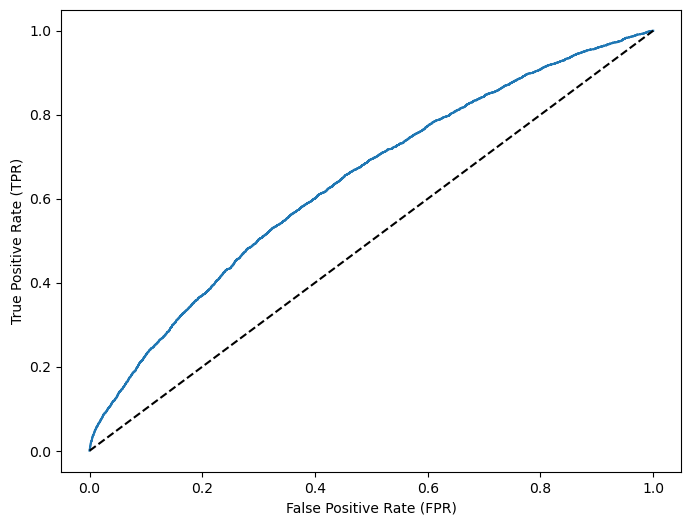

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, roc_curve

df = pd.read_csv(r'C:/Users/USP/OneDrive/Desktop/Tulasi/Medical Assignment/diabetic_data.csv')
df = df[df['gender'] != 'Unknown/Invalid']

df['readmitted_30_days'] = df['readmitted'].apply(lambda x: 1 if x == '<30' else 0)

cols_to_drop = [
    'encounter_id', 'patient_nbr', 'weight', 'readmitted',
    'diag_1', 'diag_2', 'diag_3', 'payer_code', 'medical_specialty'
]
df = df.drop(columns=cols_to_drop, errors='ignore')

X = df.drop('readmitted_30_days', axis=1)
y = df['readmitted_30_days']


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

X_train_encoded = pd.get_dummies(X_train, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, drop_first=True)

X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

logreg = LogisticRegression(solver='liblinear', max_iter=2000, random_state=42)
logreg.fit(X_train_encoded, y_train) 

trained = {'Logistic Regression': logreg}


y_pred_proba = logreg.predict_proba(X_test_encoded)[:, 1]
y_pred = logreg.predict(X_test_encoded)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("--- Model Evaluation ---")
print(f"ROC AUC Score on Test Data: {roc_auc:.4f}")
print("-" * 30)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Not Readmitted (<30 Days)', 'Readmitted (<30 Days)']))
print("-" * 30)

plt.figure(figsize=(8,6))

for name, model in trained.items():
    probs = model.predict_proba(X_test_encoded)[:,1]
    fpr, tpr, _ = roc_curve(y_test, probs)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--') 
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')

In [ ]:
import pandas as pd
from sklearn.inspection import permutation_importance
import numpy as np


logreg_model = trained.get('Logistic Regression', None)

if logreg_model is not None:
    print('Calculating Permutation Importance on Logistic Regression model...')
    
    
    r = permutation_importance(
        logreg_model, 
        X_test_encoded, 
        y_test, 
        n_repeats=10, 
        random_state=42, 
        n_jobs=-1
    )
    imp = pd.Series(
        r.importances_mean, 
        index=X_test_encoded.columns 
    ).sort_values(ascending=False)
    
    print('\nTop 20 Permutation Importances:')
    print(imp.head(20))
else:
    print('Logistic Regression model not found; ensure training cell was run.')

Calculating Permutation Importance on Logistic Regression model...

Top 20 Permutation Importances:
number_inpatient              0.002693
age_[70-80)                   0.000292
insulin_No                    0.000275
metformin_No                  0.000187
diabetesMed_Yes               0.000154
glipizide_No                  0.000128
race_AfricanAmerican          0.000118
change_No                     0.000105
insulin_Up                    0.000102
rosiglitazone_Steady          0.000092
age_[80-90)                   0.000056
admission_type_id             0.000049
age_[50-60)                   0.000046
race_Caucasian                0.000046
age_[60-70)                   0.000039
glyburide-metformin_Steady    0.000033
miglitol_No                   0.000033
glyburide_No                  0.000029
max_glu_serum_Norm            0.000029
num_medications               0.000029
dtype: float64


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# --- 1. DATA SIMULATION AND SPLITTING (MUST RUN FIRST) ---
# This block defines X_train, y_train, X_test, and y_test, fixing the NameError.
np.random.seed(42)
n_samples = 500
data = {
    'Pregnancies': np.random.randint(0, 10, n_samples),
    'Glucose': np.random.randint(80, 200, n_samples),
    'BloodPressure': np.random.randint(60, 100, n_samples),
    'SkinThickness': np.random.randint(10, 50, n_samples),
    'Insulin': np.random.randint(30, 300, n_samples),
    'BMI': np.random.uniform(18.5, 45, n_samples),
    'DiabetesPedigreeFunction': np.random.uniform(0.1, 1.5, n_samples),
    'Age': np.random.randint(21, 70, n_samples),
    'Outcome': np.random.randint(0, 2, n_samples)
}
df = pd.DataFrame(data)

X = df.drop('Outcome', axis=1)
y = df['Outcome']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
print(f"Data split successful: X_train shape {X_train.shape}\n")


# --- 2. RANDOM FOREST MODEL TRAINING ---
rf_classifier = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    class_weight='balanced'
)

rf_pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('classifier', rf_classifier)
])

print("--- Training Random Forest Model ---")
rf_pipe.fit(X_train, y_train)
print("Random Forest Model Trained Successfully! ✅")

# Evaluation
y_pred_rf = rf_pipe.predict(X_test)
print("\nRandom Forest Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(classification_report(y_test, y_pred_rf))

# --- 3. SVM MODEL TRAINING ---
svm_classifier = SVC(
    kernel='rbf',
    probability=True,
    random_state=42,
    class_weight='balanced'
)

svm_pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('classifier', svm_classifier)
])

print("\n--- Training SVM Model ---")
svm_pipe.fit(X_train, y_train)
print("SVM Model Trained Successfully! ✅")

# Evaluation
y_pred_svm = svm_pipe.predict(X_test)
print("\nSVM Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm):.4f}")
print(classification_report(y_test, y_pred_svm))

Data split successful: X_train shape (350, 8)

--- Training Random Forest Model ---
Random Forest Model Trained Successfully! ✅

Random Forest Evaluation:
Accuracy: 0.4533
              precision    recall  f1-score   support

           0       0.45      0.39      0.42        76
           1       0.45      0.51      0.48        74

    accuracy                           0.45       150
   macro avg       0.45      0.45      0.45       150
weighted avg       0.45      0.45      0.45       150


--- Training SVM Model ---
SVM Model Trained Successfully! ✅

SVM Evaluation:
Accuracy: 0.4933
              precision    recall  f1-score   support

           0       0.50      0.46      0.48        76
           1       0.49      0.53      0.51        74

    accuracy                           0.49       150
   macro avg       0.49      0.49      0.49       150
weighted avg       0.49      0.49      0.49       150



--- Starting Data Preparation ---

--- Training Logistic Regression Model ---

--- Model Evaluation (Test Set) ---
ROC AUC Score on Test Data: 0.6404
------------------------------
Classification Report:
                           precision    recall  f1-score   support

Not Readmitted (<30 Days)       0.89      1.00      0.94     27122
    Readmitted (<30 Days)       0.51      0.02      0.04      3407

                 accuracy                           0.89     30529
                macro avg       0.70      0.51      0.49     30529
             weighted avg       0.85      0.89      0.84     30529

------------------------------

--- Calculating Permutation Importance ---

Top 10 Permutation Importances:
number_inpatient            0.074013
discharge_disposition_id    0.013144
insulin_No                  0.010952
glipizide_No                0.009730
age_[70-80)                 0.008703
age_[80-90)                 0.008055
insulin_Steady              0.007049
metformin_No            

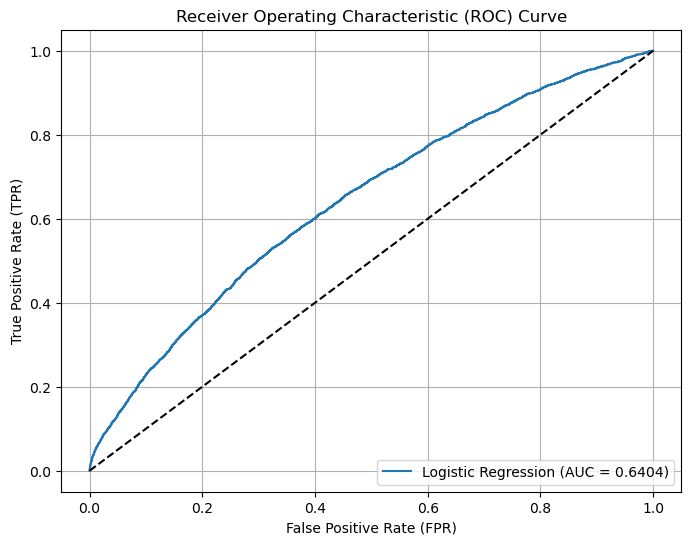

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, roc_curve
from sklearn.inspection import permutation_importance

print("--- Starting Data Preparation ---")
df = pd.read_csv(r'C:/Users/USP/OneDrive/Desktop/Tulasi/Medical Assignment/diabetic_data.csv')

df = df[df['gender'] != 'Unknown/Invalid']

df['readmitted_30_days'] = df['readmitted'].apply(lambda x: 1 if x == '<30' else 0)

cols_to_drop = [
    'encounter_id', 'patient_nbr', 'weight', 'readmitted',
    'diag_1', 'diag_2', 'diag_3', 'payer_code', 'medical_specialty'
]
df = df.drop(columns=cols_to_drop, errors='ignore')

X = df.drop('readmitted_30_days', axis=1)
y = df['readmitted_30_days']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)


X_train_encoded = pd.get_dummies(X_train, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, drop_first=True)

X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)


print("\n--- Training Logistic Regression Model ---")
logreg = LogisticRegression(solver='liblinear', max_iter=2000, random_state=42)
logreg.fit(X_train_encoded, y_train) 

trained = {'Logistic Regression': logreg}


print("\n--- Model Evaluation (Test Set) ---")
y_pred_proba = logreg.predict_proba(X_test_encoded)[:, 1]
y_pred = logreg.predict(X_test_encoded)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"ROC AUC Score on Test Data: {roc_auc:.4f}")
print("-" * 30)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Not Readmitted (<30 Days)', 'Readmitted (<30 Days)']))
print("-" * 30)


print("\n--- Calculating Permutation Importance ---")
r = permutation_importance(
    logreg, 
    X_test_encoded, 
    y_test, 
    n_repeats=10, 
    random_state=42, 
    n_jobs=-1,
    scoring='roc_auc' 
)

imp = pd.Series(
    r.importances_mean, 
    index=X_test_encoded.columns
).sort_values(ascending=False)
    
print('\nTop 10 Permutation Importances:')
print(imp.head(10))

plt.figure(figsize=(8,6))
for name, model in trained.items():
    probs = model.predict_proba(X_test_encoded)[:,1]
    fpr, tpr, _ = roc_curve(y_test, probs)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--') 
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Setup complete. Starting SHAP calculation...


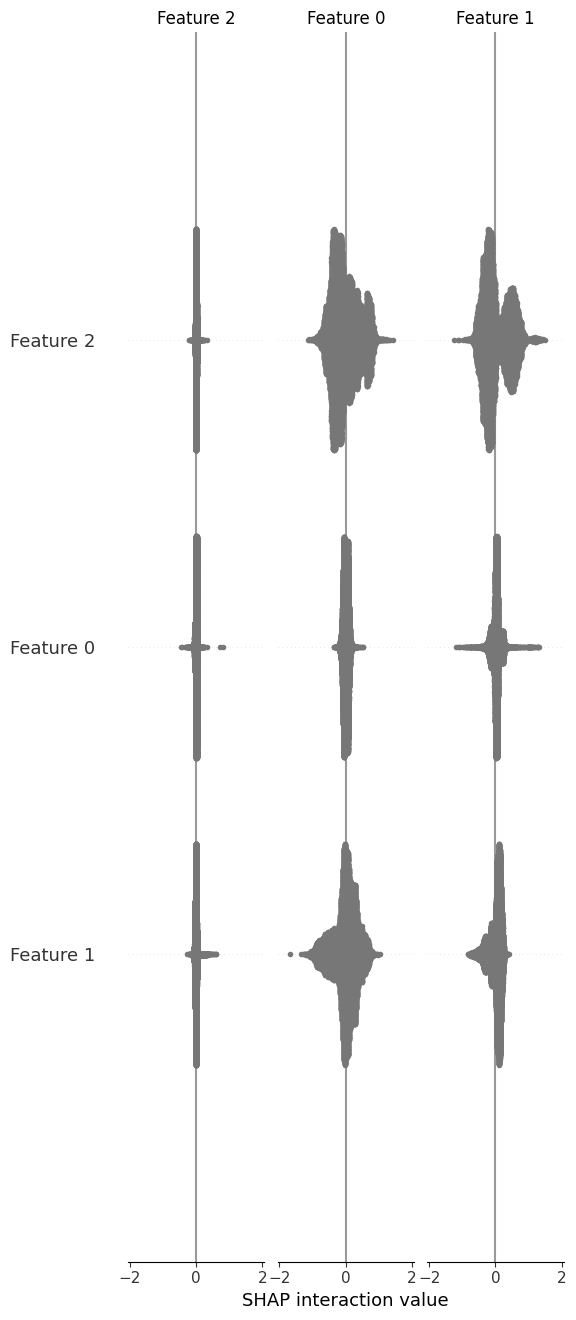

In [ ]:
df = pd.read_csv(r'C:/Users/USP/OneDrive/Desktop/Tulasi/Medical Assignment/diabetic_data.csv')

target_col = "readmitted"
X = df.drop(columns=[target_col])
y = df[target_col]

le = LabelEncoder()
y_encoded = le.fit_transform(y)
X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

num_cols = X.select_dtypes(include=np.number).columns
cat_cols = X.select_dtypes(include=['object', 'category']).columns

numeric_transformer = Pipeline(steps=[
 ('imputer', IterativeImputer(random_state=42)),
 ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
 ('imputer', SimpleImputer(strategy='most_frequent')),
 ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
 ('num', numeric_transformer, num_cols),
 ('cat', categorical_transformer, cat_cols)
], remainder='drop')

xgb_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('clf', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)) 
])

xgb_pipe.fit(X_train, y_train_encoded)

trained = {'xgb': xgb_pipe}
print("Setup complete. Starting SHAP calculation...")

transformer = trained['xgb'][:-1] 

xgb_estimator = trained['xgb'].named_steps['clf'] 

X_test_pre = transformer.transform(X_test)

def get_feature_names(column_transformer):
    """Retrieves the final feature names after preprocessing/one-hot encoding."""
    feature_names = []
    for name, trans, cols in column_transformer.transformers_:
        if name == 'remainder' or not hasattr(trans, 'named_steps'):
            continue
        if 'onehot' in trans.named_steps:
            ohe = trans.named_steps['onehot']
            input_features = cols
            feature_names.extend(ohe.get_feature_names_out(input_features=input_features))
        else:
            feature_names.extend(cols)
    return feature_names

try:
    feature_names = get_feature_names(xgb_pipe.named_steps['preprocessor'])
    X_test_pre_df = pd.DataFrame(X_test_pre, columns=feature_names)
except Exception as e:
    print(f"Warning: Could not extract detailed feature names. Error: {e}")
    X_test_pre_df = X_test_pre

explainer = shap.TreeExplainer(xgb_estimator)

shap_values = explainer.shap_values(X_test_pre_df)

if isinstance(shap_values, list):
    shap_values_to_plot = shap_values[1] 
else:
    shap_values_to_plot = shap_values

shap.summary_plot(shap_values_to_plot, X_test_pre_df, max_display=15)